In [34]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from sources.model import BeliefAutoencoder, gumbel_softmax
from sources.preprocessing import preprocessing, preprocess_sentence

def set_seed(seed=20190827):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

preprocessed_data = preprocessing("data/dataset_sentence_level.csv", device='cpu')
vocab = preprocessed_data.vocab
model = BeliefAutoencoder(emb_dim=64, h_dim=128, latent_dim=16, vocab=vocab, categorical_dim=1, activation='bc')

#model.load_state_dict(torch.load("models/belief-autoencoder-bc-YP68fCFu.pth", map_location='cpu'))
#model.load_state_dict(torch.load("models/belief-autoencoder-gumbel-128-512-32-FatzuhGa.pth", map_location='cpu'))
model.load_state_dict(torch.load("models/belief-autoencoder-bc-64-128-16-H586q3U4.pth", map_location='cpu'))
model.eval()

23110


RuntimeError: Error(s) in loading state_dict for BeliefAutoencoder:
	Missing key(s) in state_dict: "lstm_encoder.weight_ih_l0", "lstm_encoder.weight_hh_l0", "lstm_encoder.bias_ih_l0", "lstm_encoder.bias_hh_l0", "lstm_encoder.weight_ih_l0_reverse", "lstm_encoder.weight_hh_l0_reverse", "lstm_encoder.bias_ih_l0_reverse", "lstm_encoder.bias_hh_l0_reverse", "lstm_decoder.weight_ih_l0", "lstm_decoder.weight_hh_l0", "lstm_decoder.bias_ih_l0", "lstm_decoder.bias_hh_l0". 
	Unexpected key(s) in state_dict: "encoder.weight_ih_l0", "encoder.weight_hh_l0", "encoder.bias_ih_l0", "encoder.bias_hh_l0", "encoder.weight_ih_l0_reverse", "encoder.weight_hh_l0_reverse", "encoder.bias_ih_l0_reverse", "encoder.bias_hh_l0_reverse", "decoder.weight_ih_l0", "decoder.weight_hh_l0", "decoder.bias_ih_l0", "decoder.bias_hh_l0", "decoder.weight_ih_l0_reverse", "decoder.weight_hh_l0_reverse", "decoder.bias_ih_l0_reverse", "decoder.bias_hh_l0_reverse". 
	size mismatch for sampling_input.weight: copying a param with shape torch.Size([16, 256]) from checkpoint, the shape in current model is torch.Size([16, 512]).
	size mismatch for z_embedding.weight: copying a param with shape torch.Size([256, 16]) from checkpoint, the shape in current model is torch.Size([64, 16]).
	size mismatch for z_embedding.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).

In [ ]:
sentences = ["you have an orange in your inventory", "you have an apple in your inventory"]
seq_lens = [len(s.split()) for s in sentences]
max_len = max(seq_lens)
vectorized = []
for s in sentences:
    idxs, tgt, seq_len = preprocess_sentence(s, vocab, max_len)
    vectorized.append(idxs)
tensorized = torch.tensor(vectorized)

seq_len = torch.tensor(seq_lens)
tensorized

In [13]:
with torch.no_grad():
    y_hat, qy = model(x=tensorized, temperature=0.5)
#qy = gumbel_softmax(qy, temperature=1e-20,latent_dim=30, categorical_dim=2, hard=True)
qy_sig = F.sigmoid(qy)
torch.round(qy_sig).squeeze(-1)

/home/ichida/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.]])

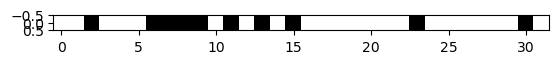

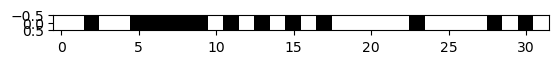

In [14]:
latent = torch.round(qy_sig).squeeze(-1)
latent = latent.view(2, 1, 32)
latent_vectors = latent.detach().cpu().numpy()
for vector in latent_vectors:
    plt.figure()
    plt.imshow(vector, cmap='gray')
    plt.show()

In [11]:
inverted_vocab = {idx: word for word, idx in vocab.items()}

y_hat.argmax(dim=-1)
idxs = y_hat.argmax(dim=-1).detach().cpu().numpy()
#idx = model.inference(qy, 20)
for idx in idxs:
    print([inverted_vocab[i] for i in idx])
    print(idx)

['you', 'have', 'an', 'orange', 'in', 'your', 'inventory', '<EOS>', 'agent']
[ 3  4 18 48 15 16 17  2 79]
['a', 'apple', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']
[  5 156   2   2   2   2   2   2   2]


In [20]:
next_word = torch.tensor([vocab['<SOS>']])
z_emb = model.z_embedding(qy[0,:,:].view(1, 60)).unsqueeze(0)  # z_emb será usado como h inicial do LSTM decoder

_, batch_size, hidden_len = z_emb.size()
hidden = z_emb.view(2, 1, int(hidden_len / 2))  # h_t
sentence = []
next_word = next_word.unsqueeze(0)
print(hidden.size(), next_word.size())
for i in range(max_len):
    sentence.append(next_word)
    next_word_emb = model.embedding(next_word)
    x, hidden = model.lstm_decoder(next_word_emb, hidden)
    #x, _ = pad_packed_sequence(x)
    x = model.output_layer(x)
    next_word = x.argmax(dim=-1)
s = torch.cat(sentence)
s

RuntimeError: shape '[1, 60]' is invalid for input of size 32

In [78]:
[inverted_vocab[i] for i in s.squeeze(-1).detach().numpy().tolist()]

['<SOS>', '<PAD>', '<PAD>', '<PAD>', '3', '<PAD>', '<PAD>']

In [76]:
qy[0,:,:], qy[1,:,:]

(tensor([[8.2806e-04, 9.9941e-01],
         [6.5952e-01, 3.7537e-01],
         [1.3543e-02, 9.8676e-01],
         [7.6780e-02, 9.3148e-01],
         [9.9985e-01, 1.1610e-04],
         [9.9946e-01, 2.8733e-04],
         [9.9685e-01, 6.6426e-03],
         [9.9788e-01, 5.5238e-03],
         [9.9924e-01, 6.1472e-04],
         [9.9751e-05, 9.9984e-01],
         [7.9383e-07, 1.0000e+00],
         [2.1500e-01, 7.1328e-01],
         [9.1362e-03, 9.8036e-01],
         [8.4709e-06, 9.9998e-01],
         [9.5656e-01, 5.3405e-02],
         [2.4508e-02, 9.5849e-01],
         [1.8293e-02, 9.8606e-01],
         [9.7044e-01, 1.9000e-02],
         [8.6453e-02, 8.4050e-01],
         [9.9999e-01, 1.7152e-05],
         [4.0549e-02, 9.8730e-01],
         [1.0000e+00, 3.3609e-07],
         [1.2495e-02, 9.7839e-01],
         [2.1059e-01, 7.9157e-01],
         [3.6606e-05, 9.9985e-01],
         [1.0368e-04, 9.9987e-01],
         [8.2068e-03, 9.9318e-01],
         [1.0000e+00, 5.1429e-07],
         [1.1812e-06